## Overview

This notebook analyzes the following statistics for the [IBM Watson Data Labs publication on medium.com](https://medium.com/ibm-watson-data-lab):

   Publication statistics:
       - Views 
       - Reads 
       - Recommendations 
       - Recommendations/reads ratio 


   Story statistics:
       - Views 
       - Reads 
       - Reads/views ratio
       - Recommendations 
       - Recommendations/reads ratio 
        
   Author statistics:     
       - Total views
       - Total reads
       - Total recommendations
       - Average reads/views ratio
       - Average recommendations/reads ratio

   Tag statistics:     
       - Total views
       - Total reads
       - Total recommendations
       - Average reads/views ratio
       - Average recommendations/reads ratio

  The measures are defined as follows:
     - Views: Number of visitors who landed on the story page 
     - Reads: Number of visitors that have read the complete story (this is an estimate)
     - Recommendations: Number of visitors that have recommended the story
     - Reads/views ratio (derived) average number of visitors that read the entire story (and not just part of it)
     - Recommendations/reads ratio (derived) average number of visitors that liked a story after reading it
     

 > A higher value is better for all measures.

In [1]:
import pixiedust
import re

Pixiedust database opened successfully


In [2]:

# @hidden_cell
credentials = {
  "auth_url": "https://identity.open.softlayer.com",
  "projectId": "**projectId**",
  "region": "**region**",
  "userId": "**userId**",
  "username": "username",
  "password": "**password**",
  "domainId": "**domainId**",
  "domainName": "**domainName**",    
}

container = 'medium-dot-com-metrics'

In [3]:
# load scraped stats from Object Storage

from io import StringIO
import requests
import json
import pandas as pd

# This function accesses a file in your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def get_object_storage_file_with_credentials(credentials, container, filename):
    """This functions returns a StringIO object containing
    the file content from Bluemix Object Storage."""

    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': credentials['username'],'domain': {'id': credentials['domainId']},
            'password': credentials['password']}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO(resp2.text)

# Your data file was loaded into a StringIO object and you can process the data.
# Please read the documentation of pandas to learn more about your possibilities to load your data.
# pandas documentation: http://pandas.pydata.org/pandas-docs/stable/io.html
stats_df = pd.read_csv(get_object_storage_file_with_credentials(credentials, container, 'data.csv'), encoding='utf-8')
meta_df = pd.read_csv(get_object_storage_file_with_credentials(credentials, container, 'metadata.csv'), encoding='utf-8', dtype={'title':str, 'author':str, 'url':str, 'tags':str})

In [4]:
if len(stats_df.index) != len(meta_df.index):
    print 'Warning! Statistics and metadata are out of sync:'
    print 'Medium stats dataframe dimensions: {} (rows, columns)'.format(stats_df.shape)
    print 'Metadata dataframe dimensions: {} (rows, columns)'.format(meta_df.shape)    
else:
    print 'Both data sets contain {} rows'.format(len(stats_df.index))

Both data sets contain 73 rows


In [5]:
analysis_df = pd.merge(stats_df, meta_df, how='left', on='title')

from datetime import datetime
today = datetime.now().date()

def calcElapsed(col):
    d = datetime.strptime(col, '%Y-%m').date()
    return ((today.year - d.year) * 12 + today.month - d.month) + 1

# calculate for how many month a story has been published
analysis_df['duration'] = analysis_df['full_month'].apply(calcElapsed)

def calcAvgInt(col1, col2):
    return int(col1/col2)

analysis_df['avg_views'] = analysis_df.apply(lambda row: calcAvgInt(row['views'],row['duration']), axis=1)
analysis_df['avg_reads'] = analysis_df.apply(lambda row: calcAvgInt(row['reads'],row['duration']), axis=1)
analysis_df['avg_recommends'] = analysis_df.apply(lambda row: calcAvgInt(row['recommends'],row['duration']), axis=1)

# calculate recommendations/reads ratio
analysis_df['rr ratio'] = analysis_df['recommends'] / analysis_df['reads']

# calculate reads/views ratio
analysis_df['rv ratio'] = analysis_df['reads'] / analysis_df['views']

analysis_df['count'] = 1

print 'Analysis dataframe dimensions: {} (rows, columns)'.format(analysis_df.shape)
analysis_df.head(3)

Analysis dataframe dimensions: (73, 18) (rows, columns)


,title,year,full_month,month,views,reads,read_ratio,recommends,author,url,tags,duration,avg_views,avg_reads,avg_recommends,rr ratio,rv ratio,count
0,Visualizing weather data as a PixieApp,2017,2017-08,8,20,13,65,1,JG,https://medium.com/ibm-watson-data-lab/visuali...,"Data Science,Weather Apps,Geospatial,Data Visu...",1,20,13,1,0.076923,0.650000,1
1,Add Redis To Your Serverless Application,2017,2017-08,8,83,33,40,7,LM,https://medium.com/ibm-watson-data-lab/add-red...,"Serverless,Alexa,Amazon Echo",1,83,33,7,0.212121,0.397590,1
2,Trigger Periodic OpenWhisk Actions,2017,2017-08,8,83,48,58,2,LM,https://medium.com/ibm-watson-data-lab/trigger...,"Serverless,Openwhisk,Ibm Bluemix,Web Developme...",1,83,48,2,0.041667,0.578313,1


In [6]:
# create tag dataframe
tag_stats = {}
tag_associations = []
for row in analysis_df.itertuples():
    if row[11] is not None:
        for tag in row[11].split(','):
            tag = tag.strip()
            if tag in tag_stats:
                #print 'Updating ' + tag + ' ' + str(tag_stats[tag])
                tag_stats[tag]['count'] += 1
                tag_stats[tag]['views'] += row[5]
                tag_stats[tag]['reads'] += row[6]
                tag_stats[tag]['recommends'] += row[8]
                #print 'Updated  ' + tag + ' ' + str(tag_stats[tag])
            else:
                tag_stats[tag] = {
                                    'count': 1,
                                    'views': row[5],
                                    'reads': row[6],
                                    'recommends': row[8],                         
                }
                #print tag + ' ' + str(tag_stats[tag])
                
            tag_associations.append((tag, row[1], row[3], row[10]))     

tag_associations_df = pd.DataFrame(tag_associations, columns=['tag','title','full_month', 'url'])
            
# http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.from_dict.html                
tag_analysis_df = pd.DataFrame.from_dict(tag_stats, orient='index').reset_index().rename(columns={"index": "tag"})

def calcAvgInt(col1, col2):
    return int(col1/col2)

tag_analysis_df['avg_views'] = tag_analysis_df.apply(lambda row: calcAvgInt(row['views'],row['count']), axis=1)
tag_analysis_df['avg_reads'] = tag_analysis_df.apply(lambda row: calcAvgInt(row['reads'],row['count']), axis=1)
tag_analysis_df['avg_recommends'] = tag_analysis_df.apply(lambda row: calcAvgInt(row['recommends'],row['count']), axis=1)

# calculate recommendations/reads ratio for each tag
tag_analysis_df['rr ratio'] = tag_analysis_df['recommends'] / tag_analysis_df['reads']

# calculate reads/views ratio
tag_analysis_df['rv ratio'] = tag_analysis_df['reads'] / tag_analysis_df['views']

# medium.com tag URL
tag_analysis_df['url'] = 'https://medium.com/search?q=' + tag_analysis_df['tag'].str.replace(' ','+')

tag_analysis_df.head(3)

,tag,count,reads,recommends,views,avg_views,avg_reads,avg_recommends,rr ratio,rv ratio,url
0,API,1,355,19,550,550,355,19,0.053521,0.645455,https://medium.com/search?q=API
1,Alexa,2,130,15,297,148,65,7,0.115385,0.437710,https://medium.com/search?q=Alexa
2,Amazon Echo,2,130,15,297,148,65,7,0.115385,0.437710,https://medium.com/search?q=Amazon+Echo


***
## Publication statistics

 - Stories per month
 - Reads/views correlation
 - Recommends/views correlation
 - Total number of views/reads/recommendations grouped by story publication month


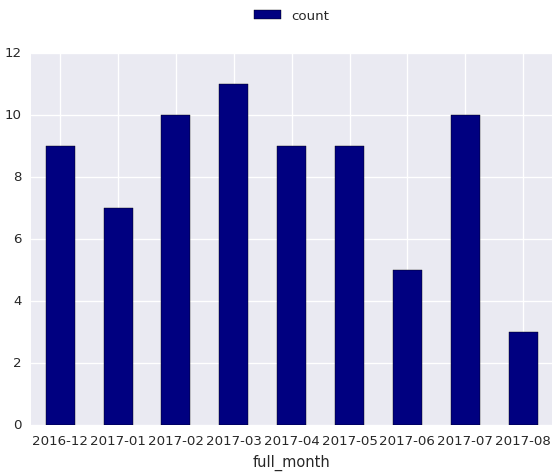

In [7]:
# number of posts per month
display(analysis_df)


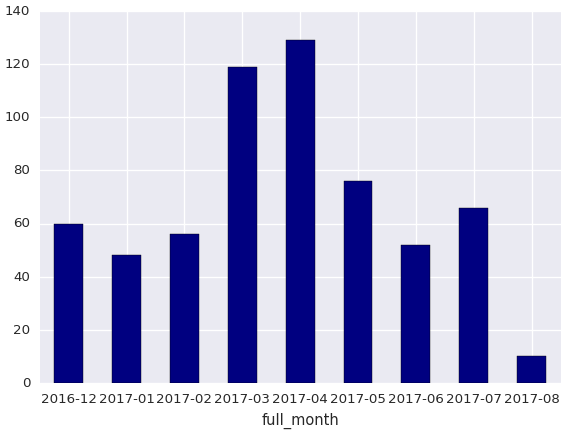

In [8]:
# views/reads/recommendations per month
display(analysis_df)

Reads/views (RV) ratio: How many people who open a story page actually read the entire story? Refer to the RV story stats chart further down for details.


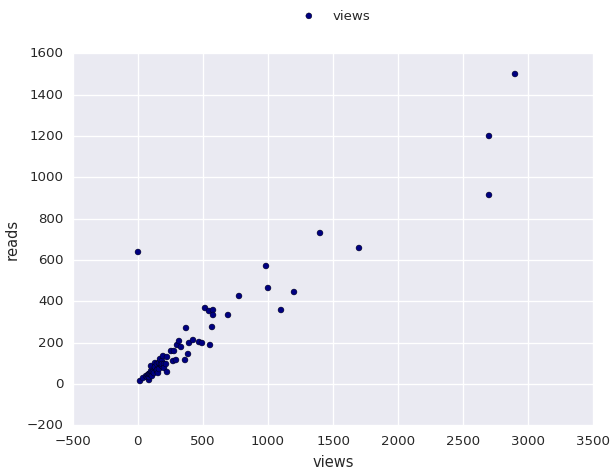

In [9]:
# correlation between reads and views
display(analysis_df)

Recommends/reads (RR) ratio: How many people who viewed/read a story recommended it? Refer to the RR story stats chart further down for details.


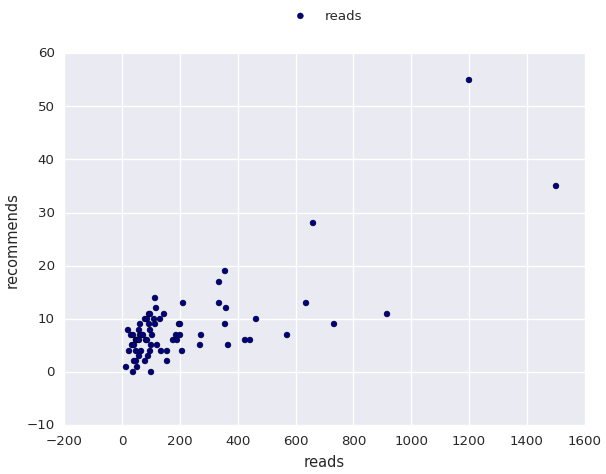

In [10]:
# correlation between recommendations and reads
display(analysis_df)

***

## Story statistics

### Views, reads and recommendations

Identify how many people have viewed/read/recommended a story:
 - Options > Values: views
 - Options > Values: reads (default)
 - Options > Values: recommends


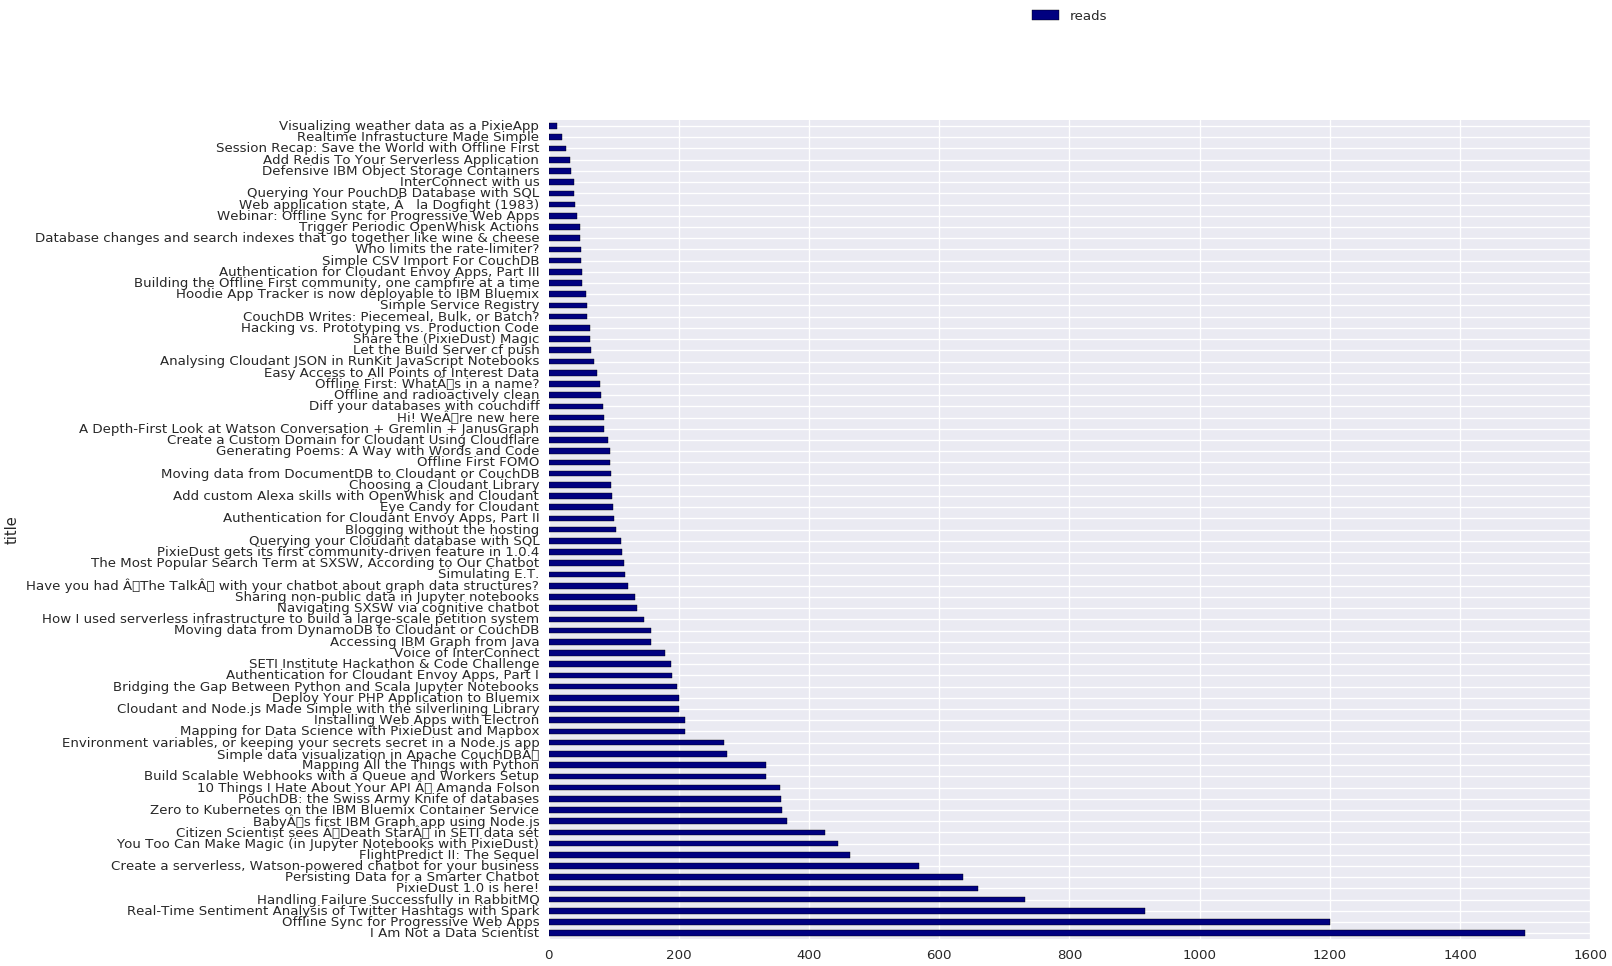

In [11]:
# views/reads/recommends per story
display(analysis_df)

### Conversion ratios

Calculate reads/views and recommendations/reads ratios for each story. A higher value is better, with 0 indicatig that nobody read/liked a story (boo!) and 1 that everybody read/liked a story (yay!)

Example: 1 out of 10 readers recommend story "The secret to maximizing story recommendations."

Recap: 
 * Views represent the number of visitors that accessed a story page. 
 * Reads represent the approximate number of visitors that read the story.
 * Recommends represent the number of visitors that liked a story.
 
To display the ratios select 
 * `Options` > `Values` : `rv ratio` or
 * `Options` > `Values` : `rr ratio` (default)


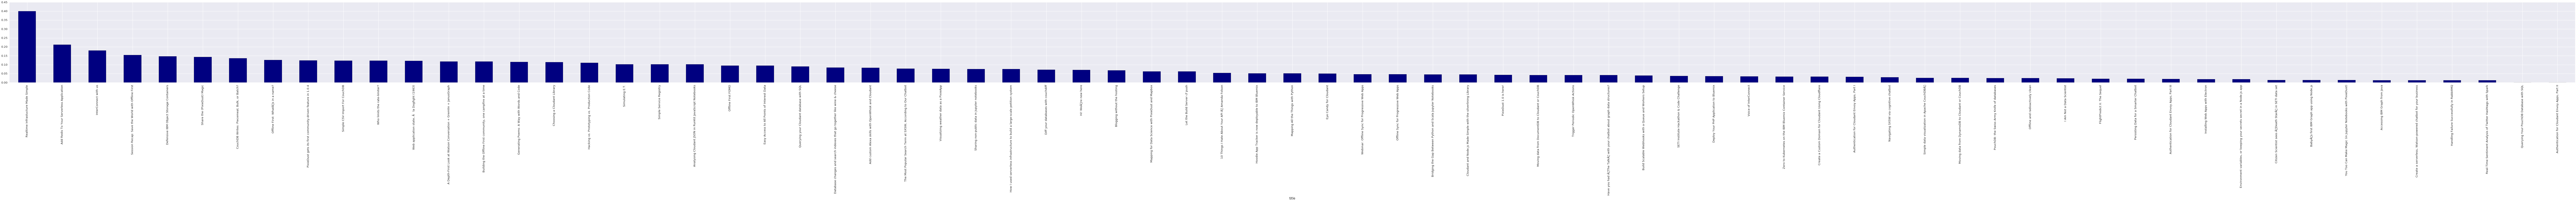

In [12]:
# recommendation/reads or reads/views ratios
display(analysis_df)

***

## Author statistics

### Views/reads/recommends for each author

To display the stats select one of these measures
 * `Options` > `Values` : `views`
 * `Options` > `Values` : `reads` (default)
 * `Options` > `Values` : `recommends`
 
and the desired aggregation 

 * `Options` > `Aggregation` : `SUM` (default)
 * `Options` > `Aggregation` : `AVG` 


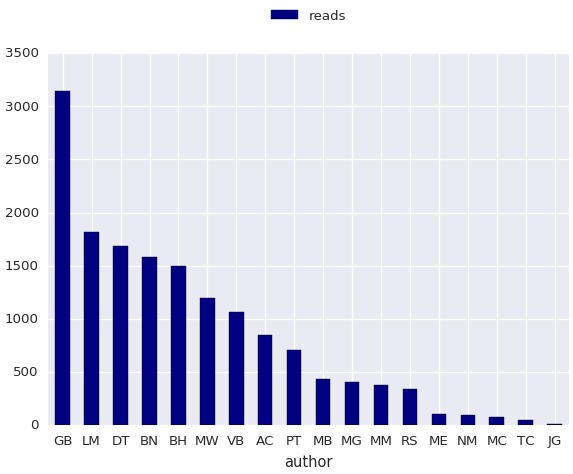

In [13]:
# higher values are better 
display(analysis_df)

### Recommends/reads and reads/views ratios for each author

To display the ratios for each author select 
 * `Options` > `Values` : `rv ratio` 
 * `Options` > `Values` : `rr ratio` (default) 


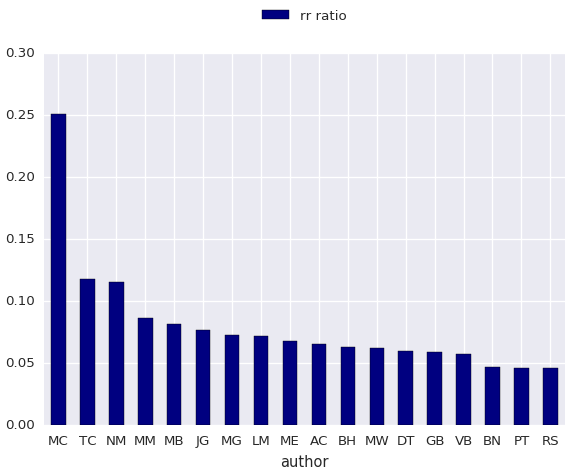

In [14]:
# recommendation ratio author (higher is better)
display(analysis_df)

***
## Tag statistics

Each story is associated with zero or more tags. For example, a story about PixieDust might be tagged using `Data Science`


### Tag frequencies


To display how frequently stories with a particular tag were viewed/read/recommended choose
 * `Options` > `Values` : `views` 
 * `Options` > `Values` : `avg_views` 
 * `Options` > `Values` : `reads` (default) 
 * `Options` > `Values` : `avg_reads` 
 * `Options` > `Values` : `recommends` 
 * `Options` > `Values` : `avg_recommends`
 
Example: Stories tagged with "ice cream" were read 5,000 times. Assuming that 10 sories were associated with the tag, the average reads is 500.


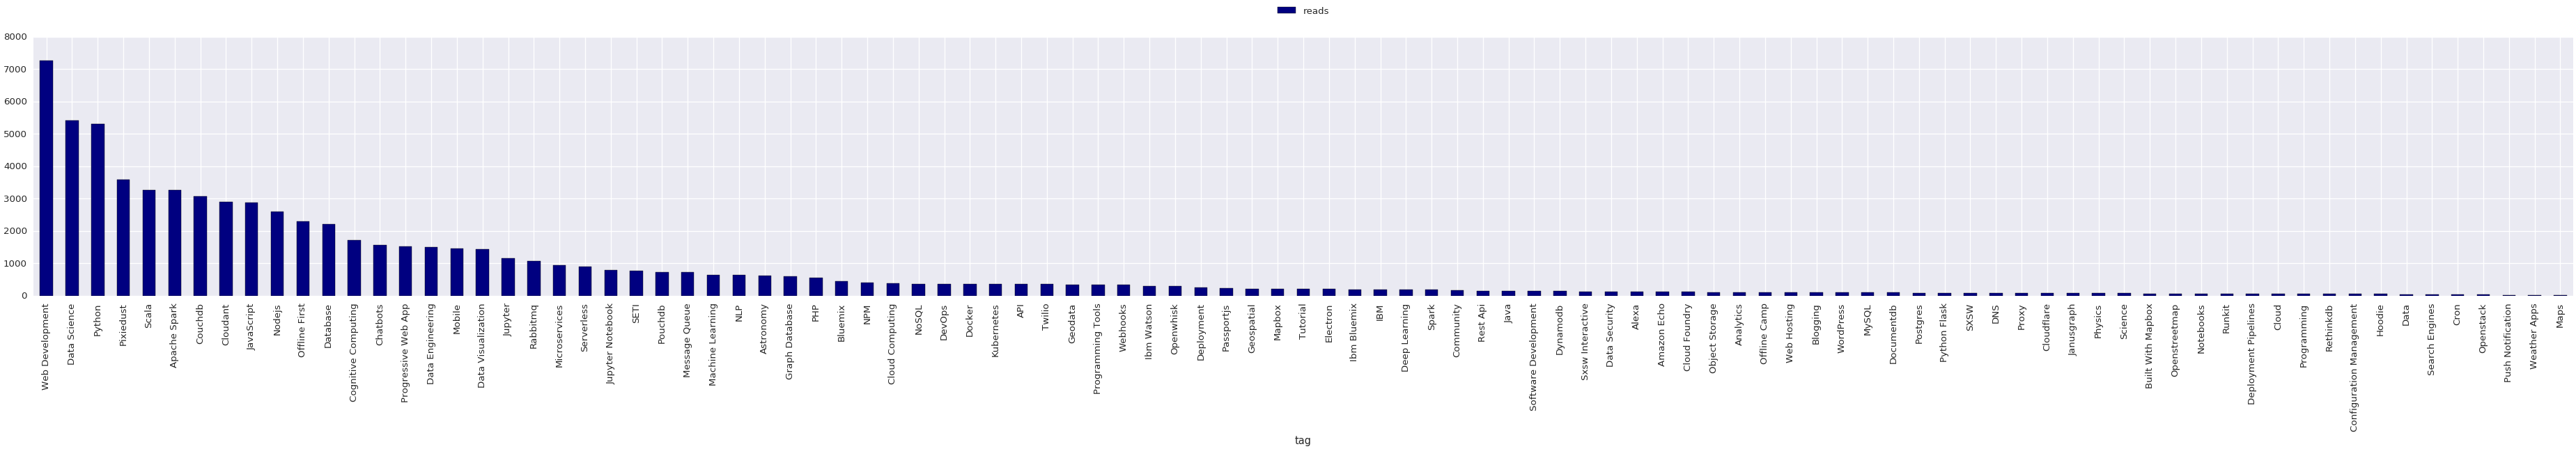

In [15]:
display(tag_analysis_df)

### Recommends/reads and reads/views ratios for each tag

To display the ratios for each tag select 
 * `Options` > `Values` : `rv ratio` 
 * `Options` > `Values` : `rr ratio` (default) 


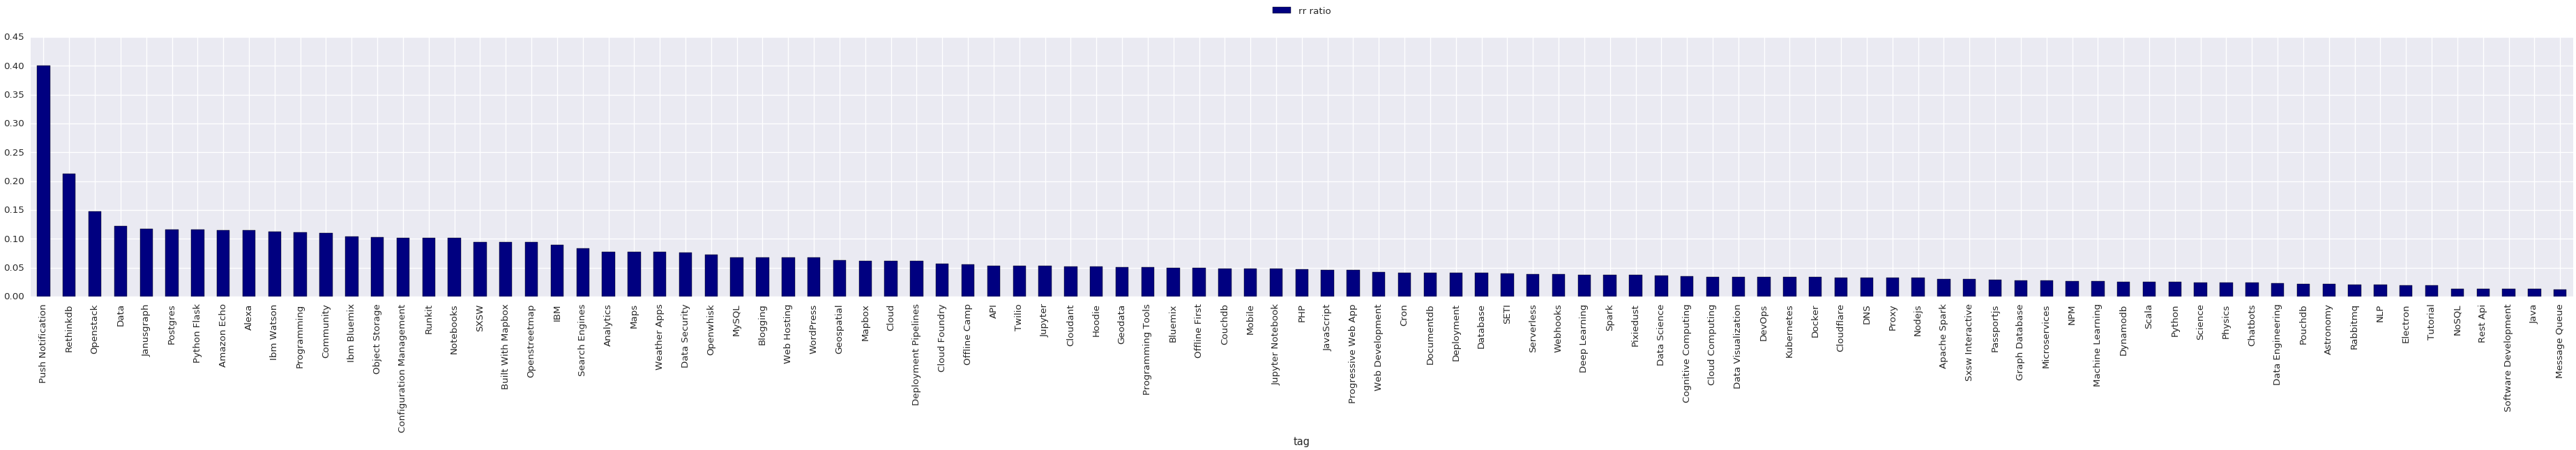

In [16]:
display(tag_analysis_df)

### Tag/story associations

Identify stories that are associated with a particular tag

In [17]:
tag = 'Data Science'
display(tag_associations_df[tag_associations_df['tag'] == tag])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Related stories

Explore other stories covering these topics:

In [18]:
for row in tag_analysis_df.itertuples(): 
    print 'Stories tagged "' + row[1] + '": ' + row[11]

Stories tagged "API": https://medium.com/search?q=API
Stories tagged "Alexa": https://medium.com/search?q=Alexa
Stories tagged "Amazon Echo": https://medium.com/search?q=Amazon+Echo
Stories tagged "Analytics": https://medium.com/search?q=Analytics
Stories tagged "Apache Spark": https://medium.com/search?q=Apache+Spark
Stories tagged "Astronomy": https://medium.com/search?q=Astronomy
Stories tagged "Blogging": https://medium.com/search?q=Blogging
Stories tagged "Bluemix": https://medium.com/search?q=Bluemix
Stories tagged "Built With Mapbox": https://medium.com/search?q=Built+With+Mapbox
Stories tagged "Chatbots": https://medium.com/search?q=Chatbots
Stories tagged "Cloud": https://medium.com/search?q=Cloud
Stories tagged "Cloud Computing": https://medium.com/search?q=Cloud+Computing
Stories tagged "Cloud Foundry": https://medium.com/search?q=Cloud+Foundry
Stories tagged "Cloudant": https://medium.com/search?q=Cloudant
Stories tagged "Cloudflare": https://medium.com/search?q=Cloudflare
